In [1]:
import cv2
import random
import numpy as np
from os import path
import matplotlib.pyplot as plt

global ALTURA_img_assinatura
global LARGURA_img_assinatura

In [2]:
def zerar_valores_pequenos(matriz: np.ndarray, limite: float =1e-10) -> np.ndarray:
    """
    Define valores menores que o limite como zero.
    Parâmetros::
        matriz (np.ndarray): A matriz de entrada.
        limite (float): O limite abaixo do qual os valores serão zerados.
    Retorna:
        np.ndarray: Matriz com valores pequenos zerados.
    """
    return np.where(np.abs(matriz) < limite, 0, matriz)


def limites_percentuais(imagem: np.ndarray, proporcao: float = 0.06) -> tuple[float, float]:
    """
    Determina os limites inferior e superior de uma imagem usando percentis.
    Parâmetros::
        imagem (np.ndarray): Array representando a imagem.
        proporcao (float): Fração dos elementos a serem considerados extremos.
    Retorna:
        tuple: Limite inferior e limite superior.
    """
    # Converte para valores reais em float64
    imagem = imagem.real.astype(np.float64)

    # Calcula os percentis para os limites
    limite_inferior = np.percentile(imagem, proporcao * 100)
    limite_superior = np.percentile(imagem, (1 - proporcao) * 100)

    return limite_inferior, limite_superior


def normalizar_imagem(imagem: np.ndarray, proporcao: float = 0.06, img_fft=False) -> np.ndarray: 
    """
    Normaliza uma imagem para valores entre 0 e 1.
    A imagem é primeiro convertida para a parte real, se necessário, e valores pequenos são zerados.
    Parâmetros:
        - imagem (np.ndarray): Array representando a imagem a ser normalizada.
        - proporcao (float): Proporção usada para calcular limites percentuais quando `img_fft=True`.
        - img_fft (bool): Se `True`, utiliza a normalização baseada em percentis. Caso contrário, faz normalização linear.
    Retorna:
        np.ndarray: A imagem normalizada.
    """
    imagem = imagem.real.astype(np.float64)
    imagem = zerar_valores_pequenos(imagem, limite=1e-13)

    if img_fft:
        # Normalizacao Percentil
        limite_inferior, limite_superior = limites_percentuais(imagem, proporcao)
    else:
        # Normalizacao Linear
        limite_inferior = np.min(imagem)
        limite_superior = np.max(imagem)

    denominador = limite_superior - limite_inferior
    if denominador == 0:
        return imagem

    return np.clip((imagem - limite_inferior) / denominador, 0, 1)


def exibir_imagem(imagem: np.ndarray, img_fft=False, *args, **kwargs) -> None:
    """
    Função responsável por plotar a imagem.
    Parâmetros:
        - imagem (np.ndarray): Array representando a imagem a ser exibida.
        - *args: Argumentos adicionais para `plt.imshow`.
        - **kwargs: Configurações adicionais, como:
            - "title" (str): Título da imagem a ser exibida.
            - "interpolation" (str): Método de interpolação (padrão: "nearest").
            - "cmap" (str): Mapa de cores (aplicado automaticamente para imagens 1D como "gray").
            etc..
    Retorna:
        None.
    """

    imagem = normalizar_imagem(imagem, img_fft=img_fft)
    
    kwargs.setdefault("interpolation", "nearest")

    if "title" in kwargs:
        plt.title(kwargs["title"])
        kwargs.pop("title")

    if len(imagem.shape) == 1:
        kwargs["cmap"] = "gray"

    plt.imshow(imagem, *args, **kwargs)


def salvar_imagem(nome_arquivo: str, imagem: np.ndarray, img_fft=False, *args, **kwargs) -> None:
    """
    Função resposável por salvar a imagem.
    Parametros de entrada:
        - nome_arquivo (str): Caminho ou nome do arquivo onde a imagem será salva.
        - imagem (np.ndarray): Array representando a imagem.
        - *args: Argumentos adicionais a serem passados para `plt.imsave`.
        - **kwargs: Argumentos adicionais a serem passados para `plt.imsave`.
    Retorno:
        None
    """
    kwargs["dpi"] = 1
    
    if imagem.dtype != np.uint8:
        print("Normalizando e convertendo a imagem para {uint8}.")
        imagem = normalizar_imagem(imagem, img_fft=img_fft)
        imagem = (imagem * 255).round().astype(np.uint8)

    plt.imsave(nome_arquivo, imagem, *args, **kwargs)


def gerar_embaralhamento(tamanho: int, semente: int = None) -> np.ndarray:
    """
    Função resposável por gerar os índices de embaralhamento. O campo de
    "semente" (segredo) funciona como uma semente para a geração dos índices.
    Parametros de entrada:
        - tamanho (int): Tamanho da lista de índices a serem gerados.
        - semente (str): Semente para a geração dos índices.
    Retorno:
        - resultado (np.ndarray): Lista de índices embaralhados.
    """
    resultado = np.arange(tamanho)
    if semente is not None:
        random.seed(semente)
        for i in range(tamanho - 1, 0, -1):
            j = random.randint(0, i)  # Garante que o índice é válido
            resultado[i], resultado[j] = resultado[j], resultado[i]

    return resultado


def gerar_mapa_indices(shape: tuple, semente: str = None) -> tuple[np.ndarray, np.ndarray]:
    """
    Função responsavel por gerar dois arrays de índices embaralhados
    para um mapa bidimensional.
    Parametros de entrada:
        - dimensoes (tuple): Um tupla (altura, largura) representando o formato do mapa.
        - semente (str): Semente para a geração dos índices (controle aleatoriedade).
    Retorno:
        - indices_altura (np.ndarray): Array NumPy contendo os índices embaralhados para as linhas (altura).
        - indices_largura (np.ndarray): Array NumPy contendo os índices embaralhados para as colunas (largura).
    """
    altura, largura = shape[0], shape[1]

    # Gera os índices embaralhados para altura e largura
    indices_altura = gerar_embaralhamento(altura, semente).reshape((-1, 1))
    indices_largura = gerar_embaralhamento(largura, semente)

    return indices_altura, indices_largura


def normalizacao_RGB(imagem: np.ndarray) -> np.ndarray:
    """
    Função responsável por normalizar os valores de uma imagem RGB. (deixar entre 0 e 1)
    Parâmetros:
        imagem(np.ndarray): Um array representando a imagem RGB. Deve ter pelo menos 3 canais.
    Retorno:
        np.ndarray: A imagem normalizada com valores no intervalo [0, 1].
    """
    if imagem.dtype == np.uint8:
        return imagem[:,:,:3] / 255.
    else:
        return imagem[:,:,:3].astype(np.float64)


print("Funções utilitárias carregadas.")

Funções utilitárias carregadas.


In [3]:
def preparar_imagem_assinatura(
    img_original: np.ndarray,
    imagem_assinatura: np.ndarray,   
) -> np.ndarray:
    """
    Função responsável por preparar a imagem de assinatura, ajustando suas dimensões para 
    coincidir com as dimensões da imagem original.
    Parâmetros:
        - img_original (np.ndarray): A imagem original à qual a assinatura será ajustada.
        - imagem_assinatura (np.ndarray): A imagem da assinatura que será preparada.
        - caminho_saida (str): Caminho onde a imagem final preparada será salva (padrão é "imagem_assinatura_preparada.png").
    Retorna:
        - np.ndarray: A imagem de assinatura ajustada, pronta para ser usada.
    """

    imagem_assinatura_uint8 = (imagem_assinatura * 255).astype(np.uint8)

    # Converter a imagem utizando a escala da cinza com o OpenCV
    imagem_assinatura_uint8 = cv2.cvtColor(imagem_assinatura_uint8, cv2.COLOR_BGR2GRAY)
    imagem_assinatura_uint8 = cv2.merge(
        [imagem_assinatura_uint8, imagem_assinatura_uint8, imagem_assinatura_uint8]
    )

    # Obter as dimensões da imagem original
    altura, largura = imagem_assinatura_uint8.shape[:2]

    fator_multiplicador_altura = img_original.shape[0] // altura
    fator_multiplicador_largura = img_original.shape[1] // largura

    # Redimensionar a imagem de assinatura
    nova_largura = largura * fator_multiplicador_largura
    nova_altura = altura * fator_multiplicador_altura

    # Criar uma nova imagem maior (4 vezes o tamanho da imagem ampliada)
    nova_imagem = np.zeros((nova_altura, nova_largura, 3), dtype=np.uint8)

    # Replicar as imagens
    for altura_nova in range(fator_multiplicador_altura):
        for largura_nova in range(fator_multiplicador_largura):
            # Calcular os índices da imagem ampliada correspondente
            nova_imagem[
                altura*altura_nova:altura*(altura_nova+1),
                largura*largura_nova:largura*(largura_nova+1)
            ] = imagem_assinatura_uint8

    # Salvar a nova imagem
    salvar_imagem("imagem_assinatura_preparada.png", nova_imagem, img_fft=False)

    return nova_imagem


print("Funcao de Preparar Imagem de Assinatura carregada")

Funcao de Preparar Imagem de Assinatura carregada


In [4]:
def codificar_img(
	img_original: np.ndarray,
	img_assinatura: np.ndarray,
	mapa_embaralhamento: np.ndarray,
	alpha: float = None # Intensiudade
) -> tuple[np.ndarray, np.ndarray]:
    """
    Função responsável por preparar a imagem de assinatura, ajustando suas dimensões para 
    coincidir com as dimensões da imagem original. A assinatura é redimensionada e salva como uma nova imagem.
    Parâmetros:
        - img_original (np.ndarray): A imagem original à qual a assinatura será ajustada.
        - imagem_assinatura (np.ndarray): A imagem da assinatura que será preparada.
        - caminho_saida (str): Caminho onde a imagem final preparada será salva (padrão é "imagem_assinatura_preparada.png").
    Retorna:
        - np.ndarray: A imagem de assinatura ajustada, pronta para ser usada.
    """
    print("Iniciando codificação da imagem")
    
    # Preparação da imagem de assinatura
    imagem_assinatura_replicada = preparar_imagem_assinatura(img_original, img_assinatura)
    img_assinatura_normalizada = normalizacao_RGB(imagem_assinatura_replicada)

    # Normalização da imagem original
    img_original_normalizada = normalizacao_RGB(img_original)
    fft_img_original = np.fft.fft2(img_original_normalizada, None, axes=(0, 1))

    # Aplicando fftshift para centralizar as frequências
    fft_img_original = np.fft.fftshift(fft_img_original)

    # Padding da imagem de assinatura
    padding_img_assinatura = np.zeros((
        img_original_normalizada.shape[0],
        img_original_normalizada.shape[1],
        3
    ))
    padding_img_assinatura[:img_assinatura_normalizada.shape[0], :img_assinatura_normalizada.shape[1]] += img_assinatura_normalizada

    # Cálculo de intensidade (alpha), se não fornecido
    if alpha is None: # Intensidade
        limite_inferior, limite_superior = limites_percentuais(fft_img_original, proporcao=0.005)
        alpha = limite_superior - limite_inferior
        print(f"Calculando intensidade calculada {alpha}")

    # Modificação na FFT com assinatura e alpha
    emb_linhas, emb_colunas = mapa_embaralhamento[:2]

    # Revertendo o shift para o domínio correto
    fft_img_original[emb_linhas, emb_colunas] += padding_img_assinatura * alpha

    # Revertendo o shift para o domínio correto
    fft_img_original = np.fft.ifftshift(fft_img_original)

    # Reconstrução da imagem no domínio espacial
    imagem_codificada = np.fft.ifft2(fft_img_original, None, axes=(0, 1))
    imagem_codificada = imagem_codificada.real
    imagem_codificada = np.clip(imagem_codificada, 0, 1)

    return imagem_codificada, fft_img_original


print("Funcao de Codificar Imagem carregada")

Funcao de Codificar Imagem carregada


In [5]:
def ajustar_imagem_decodificada(
    img_encodificada: np.ndarray
)-> np.ndarray:
    """
    Função responsável por ajustar a imagem decodificada, calculando a média das sub-imagens extraídas.
    A imagem é dividida em sub-imagens menores, e a média pixel a pixel dessas sub-imagens é calculada
    para gerar uma versão ajustada da imagem original.
    Parâmetros:
        - img_encodificada (np.ndarray): A imagem codificada que será ajustada.
    Retorna:
        - np.ndarray: A imagem ajustada, representada como um array NumPy.
    """
    img_encodificada_uint8 = (img_encodificada.real * 255).astype(np.uint8)

    altura_sub_imagem = ALTURA_img_assinatura
    largura_sub_imagem = LARGURA_img_assinatura

    num_linhas = img_encodificada_uint8.shape[0] // altura_sub_imagem
    num_colunas = img_encodificada_uint8.shape[1] // largura_sub_imagem

    # Extrair sub-imagens e armazená-las
    sub_imagens = []
    for i in range(num_linhas):
        for j in range(num_colunas):
            # Cortar cada sub-imagem com base nos índices
            y_inicio = i * altura_sub_imagem
            y_fim = (i + 1) * altura_sub_imagem
            x_inicio = j * largura_sub_imagem
            x_fim = (j + 1) * largura_sub_imagem
            sub_imagem = img_encodificada_uint8[y_inicio:y_fim, x_inicio:x_fim]
            sub_imagens.append(sub_imagem)

    # Calcular a média pixel a pixel
    sub_imagens_array = np.array(sub_imagens, dtype=np.float32)

    # Calcular a média ao longo do eixo 0 (das várias sub-imagens)
    imagem_media = np.mean(sub_imagens_array, axis=0).astype(np.uint8)
    salvar_imagem("imagem_media.jpg", imagem_media, img_fft=False)

    return imagem_media


print("Funcao de Ajustar Imagem decodificada carregada")

Funcao de Ajustar Imagem decodificada carregada


In [6]:
def decodificar_img(
    img_codificada: np.ndarray,
    mapa_embaralhamento: np.ndarray = None,
) -> np.ndarray:
    """
    Função responsável por decodificar uma imagem a partir de sua versão codificada, utilizando
    um mapa de embaralhamento e transformações no domínio da frequência (FFT).
    A função realiza a normalização da imagem codificada, aplica a transformada rápida de Fourier
    (FFT) para obter a imagem no domínio da frequência, e então usa o mapa de embaralhamento para 
    decodificar a imagem original.
    Parâmetros:
        - img_codificada (np.ndarray): A imagem codificada a ser decodificada.
        - mapa_embaralhamento (np.ndarray): Um mapa que determina o embaralhamento dos índices
          da imagem codificada para reconstruir a imagem original.
    Retorna:
        - np.ndarray: A imagem decodificada, ajustada para valores no intervalo [0, 1].
    """
    img_codificada_normalizada = normalizacao_RGB(img_codificada)

    fft_img_codificada = np.fft.fft2(img_codificada_normalizada, None, (0, 1))
    
    # Aplicando fftshift para centralizar as frequências
    fft_img_codificada = np.fft.fftshift(fft_img_codificada)

    fator_normalizacao = img_codificada.shape[0] * img_codificada.shape[1]
    fft_img_codificada *= fator_normalizacao

    emb_linhas, emb_colunas = mapa_embaralhamento[:2]

    img_decodificada = fft_img_codificada[emb_linhas, emb_colunas]

    img_decodificada_clipada = np.clip(img_decodificada, 0, 1)

    return img_decodificada_clipada

print("Funcao de Decoficar Imagem carregada")

Funcao de Decoficar Imagem carregada


Iniciando codificação da imagem
Normalizando e convertendo a imagem para {uint8}.
Normalizando e convertendo a imagem para {uint8}.
Normalizando e convertendo a imagem para {uint8}.


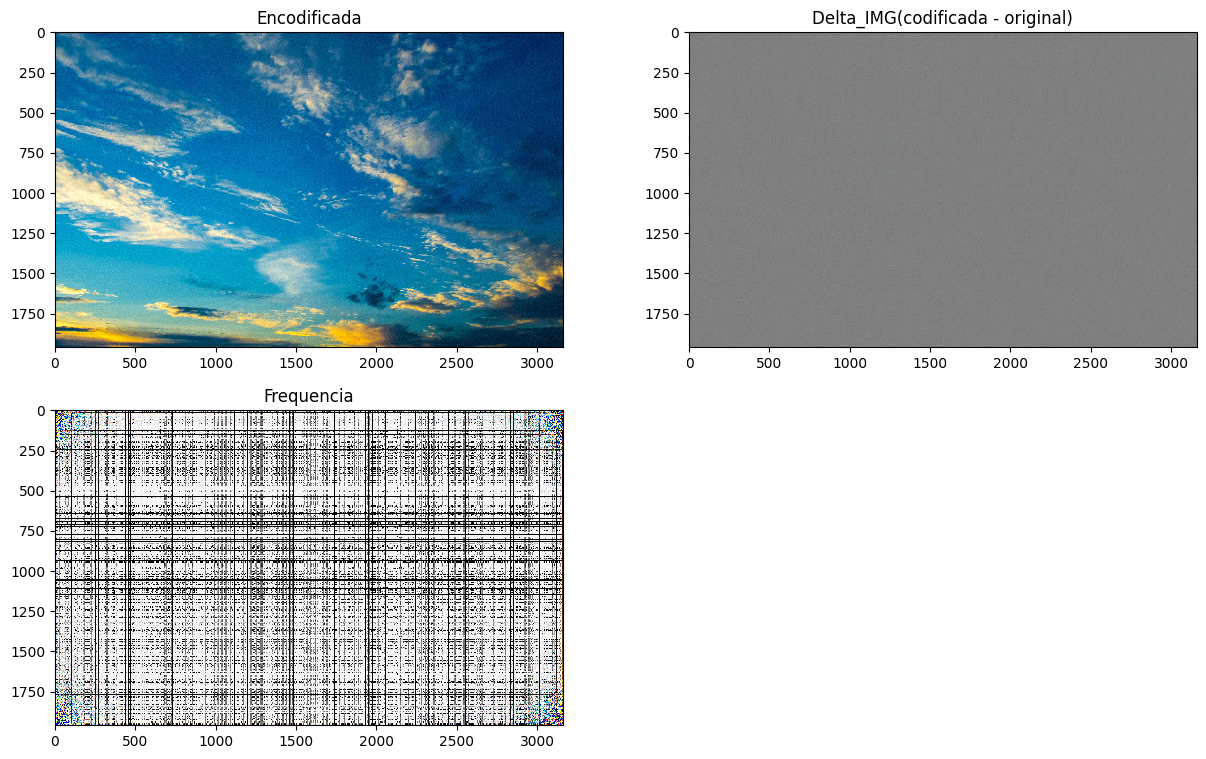

In [ ]:
#######################################################
################### Parametrização ####################
#######################################################
caminho_imagem_original = "ceu.jpg"
secret = "48b2a5d9-a800-4617-a71f-0f81daf3a968"
caminho_imagem_assinatura = "logo_ifmg.png"

# Pixels imagem de assinatura
ALTURA_img_assinatura = 118
LARGURA_img_assinatura = 427

#######################################################



# Lendo imagem original
imagem_original = plt.imread(caminho_imagem_original)

# Gerando mapa de indices para Embaralhamento
mapa_indices = gerar_mapa_indices(imagem_original.shape, secret)

# Lendo imagem de assinatura/marca d'água
imagem_assinatura = plt.imread(caminho_imagem_assinatura)

imagem_codificada, fft_img_original = codificar_img(
    imagem_original,
    imagem_assinatura,
    mapa_indices,
    350,
)

base_original, extensao_original = path.splitext(caminho_imagem_original)
base_assinatura, extensao_assinatura = path.splitext(caminho_imagem_assinatura)
saida_imagem_codificada = f"{base_original}+{base_assinatura}{extensao_original}"


plt.figure(figsize=(15, 9))

plt.subplot(221)
salvar_imagem(saida_imagem_codificada, imagem_codificada, img_fft=False)
exibir_imagem(imagem_codificada, img_fft=False, title = "Encodificada")

plt.subplot(222)
img_delta = normalizacao_RGB(imagem_original) - normalizacao_RGB(imagem_codificada)
salvar_imagem("delta_"+saida_imagem_codificada, img_delta, img_fft=False)
exibir_imagem(
    img_delta,
    img_fft=False,
    title = "Delta_IMG(codificada - original)"
)

plt.subplot(223)
salvar_imagem("freq_"+saida_imagem_codificada, fft_img_original, img_fft=True)
exibir_imagem(
    fft_img_original,
    title = "Frequencia",
    img_fft=True
)

Normalizando e convertendo a imagem para {uint8}.


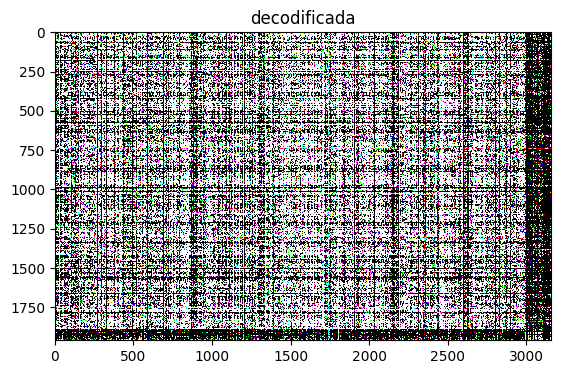

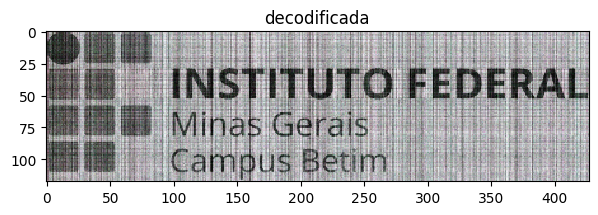

In [8]:
imagem_codificada = plt.imread(saida_imagem_codificada)

img_decodificada  = decodificar_img(
    img_codificada=imagem_codificada,
    mapa_embaralhamento=mapa_indices
)

base, ext = path.splitext("ceu.jpg")
saida_deco = "saida_decodificada"+ext


plt.figure(figsize=(7, 4))
salvar_imagem(saida_deco, img_decodificada, img_fft=True)
exibir_imagem(img_decodificada , title = "decodificada", img_fft=True)
plt.show() #display


plt.figure(figsize=(7, 4))
imagem_decodificada_ajustada = ajustar_imagem_decodificada(img_decodificada)
salvar_imagem("ajustada_"+saida_deco, imagem_decodificada_ajustada, img_fft=False)
exibir_imagem(imagem_decodificada_ajustada , title = "decodificada", img_fft=False)
plt.show() #display